In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.low_energy.atomic as atomic

# Reproducing case-B Recombination Coefficients

In [4]:
rs_vec = 10**np.arange(1,4,.5)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)
length = len(rs_vec)

In [20]:
%autoreload
# alpha_B requires many excited states to converge (see Hummer Fig. 1)
nmax = 100
Delta_f = lambda a : 0

alpha_tot=np.zeros(length)
for i, rs in enumerate(rs_vec):
    Tm = phys.Tm_std(rs)

    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, phys.TCMB(rs)/1e10, nmax, k2_tab, g)
    alpha_tot[i] = np.sum(alpha)
    
    print(rs, alpha_tot[i])
    
#!!! Need to double-check the stimulated emission coefficient

10.0 6.657370029077706e-11
31.622776601683793 2.0223260524731932e-11
100.0 6.100510373652237e-12
316.22776601683796 2.260443045103784e-12
1000.0 1.024063160379102e-12
3162.2776601683795 4.622787658563571e-13


In [21]:
# Tm^1/2 * alpha_B from Hummer 1994 MNRAS
Tm_alphaB_Hummer = np.array([
    9.283e-11, 8.823e-11, 8.361e-11,
    7.898e-11, 7.435e-11, 6.973e-11,
    6.512e-11, 6.054e-11, 5.599e-11,
    5.147e-11, 4.700e-11, 4.258e-11,
    3.823e-11, 3.397e-11, 2.983e-11,
    2.584e-11, 2.204e-11, 1.847e-11,
    1.520e-11, 1.226e-11, 9.696e-12,
    7.514e-12, 5.710e-12, 4.257e-12,
    3.117e-12, 2.244e-12, 1.590e-12,
    1.110e-12, 7.642e-13, 5.199e-13,
3.498e-13])

#Convert to eV
Tm_Hummer = 10**np.arange(1,7.2,.2)*phys.kB

alphaB_Hummer = interp1d(Tm_Hummer, Tm_alphaB_Hummer/np.sqrt(Tm_Hummer/phys.kB))

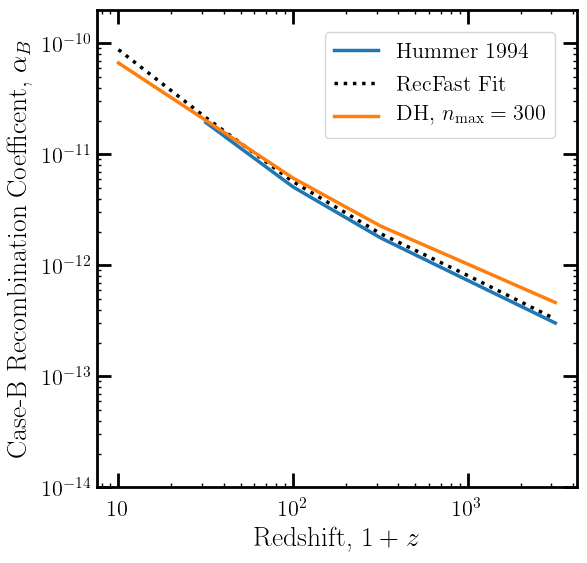

In [22]:
rs_vec = 10**np.arange(1,4,.5)
Tm_vec = phys.Tm_std(rs_vec)
plt.figure()
plt.loglog()
plt.ylim([1e-14,2e-10])

plt.plot(rs_vec[Tm_vec>8e-4], alphaB_Hummer(Tm_vec[Tm_vec>8e-4]), label='Hummer 1994')
plt.plot(rs_vec, phys.alpha_recomb(Tm_vec, 'HI'), label='RecFast Fit', color='k', linestyle=':')
plt.plot(rs_vec, alpha_tot, label=r'DH, $n_{\mathrm{max}}=300$')
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Case-B Recombination Coefficent, $\alpha_B$', fontsize=20)
plt.legend()

$\beta_B$ is obtained by detailed balance. 
First, use $x_i \beta_i \sim \frac1{g_i}e^{-E_i/T_m}\alpha_i$.
Next, assume $x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m}$. 
Finally, write the ionization term in the $x_e$ evolution equation as 
$$
\sum_i \beta_i x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m} \sim x_{2s}e^{-E_2/T_m} \alpha_B \sim \beta_B x_{2s}
$$
So a cross-cheeck of $\alpha_B$ is a cross-check of $\beta_B$.

# Deviations from TLA Assumptions

The TLA assumes that the excited states obey the detailed balance condition
$$
\begin{alignat}{1}
	\frac{x_i}{x_{2s}} = g_i e^{-(E_i-E_\alpha)/T} \, ,
\end{alignat}
$$
that the $n=2$ state obeys
$$
\begin{alignat}{1}
	x_2 = & \frac{x_{1s}e^{-E_\alpha/T} (3 R_{\text{Ly}\alpha} + \Lambda_{2s}) + x_e^2 n_H \alpha_\text{B}}{
	\frac34 R_{\text{Ly}\alpha} + \frac14 \Lambda_{2s} + \beta_\text{B}}   \, ,
\end{alignat}
$$
and that the substates satisfy 
$$
\begin{alignat}{1}
	x_{2p} = & \frac34 x_2 \\
    x_{2s} = & \frac14 x_2 \, .
\end{alignat}
$$

We also assume that the excited state abundances are so exponentially suppressed that $$x_{1s} = 1-x_e \, .$$
Let us now see if we can reproduce this behavior.

In [38]:
%autoreload
rs_vec = 10**np.arange(1,4.55,.05)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)

length = len(rs_vec)

xe_vec = phys.xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)
nH_vec  = phys.nH * rs_vec**3

#2p-1s rate without optical depth
f_Lya = np.exp(-phys.lya_eng/Tr_vec)/(1-np.exp(-phys.lya_eng/Tr_vec))
R_Lya_vec = 2**9/3**8 * phys.alpha**3 * phys.rydberg/phys.hbar * (1+f_Lya)

#Sobolev optical depth
tau_vec = atomic.tau_np_1s(2,rs_vec)
R_Lya_vec *= (1-np.exp(-tau_vec))/tau_vec

# lam_a = 2*np.pi * phys.hbar * phys.c/phys.lya_eng
# R_Lya_vec = 8*np.pi*phys.hubble(rs_vec)/(3*x1s_vec*nH_vec*lam_a**3)

#2s-1s rate
Lam2s = phys.width_2s1s_H

#Total deexcitation rate
sum_rates = (3*R_Lya_vec + Lam2s)/4

#Denominator of Peebles C factor
denom = sum_rates + phys.beta_ion(Tr_vec,'HI')

#Two numerator terms for x2 steady state solution
term1 = xe_vec**2 * nH_vec * phys.alpha_recomb(Tm_vec, 'HI')
term2 = 4 * x1s_vec * np.exp(-phys.lya_eng/Tr_vec) * sum_rates

x2_vec = (term1+term2)/denom

In [39]:
def E(n):
    return phys.rydberg/n**2

def g_nl(l):
    return 2*l+1

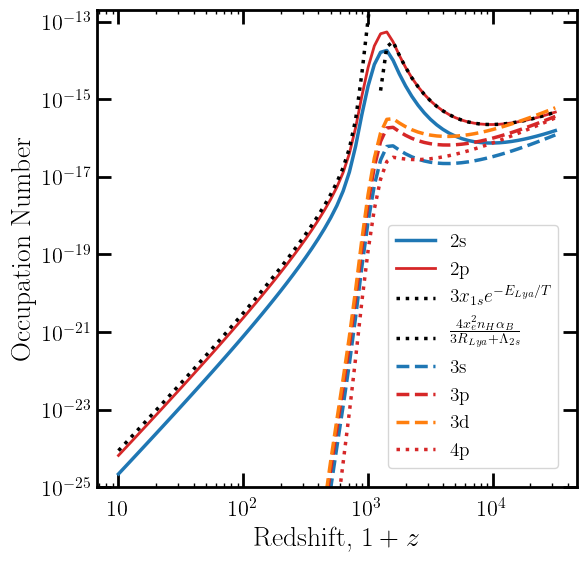

In [40]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

plt.plot(rs_vec, x2s_vec, label='2s', color='C0')
plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=2.0)
plt.plot(rs_vec[rs_vec>1.2e3], (3*x1s_vec*np.exp(-phys.lya_eng/Tr_vec))[rs_vec>1.2e3], 
         label=r'$3 x_{1s} e^{-E_{Lya} / T}$', color='k', linestyle=':')
plt.plot(rs_vec[rs_vec<1.2e3], (term1/sum_rates)[rs_vec<1.2e3], 
         label=r'$\frac{4 x_e^2 n_H \alpha_B}{3 R_{Lya} + \Lambda_{2s}}$', color='k', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C0', linestyle='--')
plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C3', linestyle='--')
plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C1', linestyle='--')
plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(fontsize=14)

Now we would like to see if $Mx = b$ produces a solution near the above lines.

### Checking Detailed Balance

In [78]:
%autoreload

#Detailed Balance between recombination and ionization
rs = 3e3
Tr = phys.TCMB(rs)
Tm = Tr#phys.Tm_std(rs)
xe = phys.xHII_std(rs)
nH = phys.nH * rs**3
x1s = phys.xHI_std(rs)

nmax=9
R = atomic.populate_radial(nmax)
BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)
beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)

hplanck=2*np.pi*phys.hbar
mu_e = phys.me/(1 + phys.me/phys.mp)
lam_T = hplanck*phys.c/(2*np.pi * mu_e * Tr)**(1/2)

for n in np.arange(1,nmax+1):
    for l in np.arange(0,n):
        print(n,l,':', beta[n][l]/(
            alpha[n][l]*np.exp(-E(n)/Tr)/g_nl(l)/lam_T**3))#xe**2*nH * 

1 0 : 1.0000000000000016
2 0 : 0.9999999999999997
2 1 : 1.0
3 0 : 1.0
3 1 : 1.0
3 2 : 0.9999999999999999
4 0 : 1.0000000000000002
4 1 : 1.0
4 2 : 1.0000000000000002
4 3 : 1.0000000000000002
5 0 : 1.0000000000000004
5 1 : 1.0000000000000004
5 2 : 1.0
5 3 : 1.0000000000000002
5 4 : 1.0000000000000002
6 0 : 1.0
6 1 : 1.0000000000000004
6 2 : 1.0000000000000002
6 3 : 1.0000000000000002
6 4 : 1.0000000000000002
6 5 : 0.9999999999999998
7 0 : 0.9999999999999998
7 1 : 1.0000000000000002
7 2 : 1.0000000000000002
7 3 : 1.0
7 4 : 0.9999999999999998
7 5 : 1.0000000000000002
7 6 : 1.0000000000000002
8 0 : 0.9999999999999999
8 1 : 1.0
8 2 : 1.0
8 3 : 1.0
8 4 : 0.9999999999999998
8 5 : 1.0
8 6 : 1.0
8 7 : 0.9999999999999999
9 0 : 0.9999999999999998
9 1 : 1.0
9 2 : 0.9999999999999998
9 3 : 0.9999999999999999
9 4 : 0.9999999999999997
9 5 : 1.0000000000000002
9 6 : 1.0000000000000002
9 7 : 1.0000000000000002
9 8 : 0.9999999999999999


In [79]:
%autoreload
#Saha equilibrium

rhs = lam_T**-3 / (phys.nH*rs**3) * np.exp(-phys.rydberg/Tr)
phys.xHI_std(rs) * rhs/xe**2

0.9999999999999999

In [75]:
# Detailed Balance amongst the bound-bound transition rates
print('n1 l n2')
n1,l = 1,0
for n2 in np.arange(2,nmax+1):
    Ennp = E(n1)-E(n2)
    print(n1,'',l,n2,':',
          BB['up'][n1][n2][l]/(BB['dn'][n2][n1][l+1])/(
         np.exp(-Ennp/Tr)*g_nl(l+1)/g_nl(l)))
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
1  0 2 : 1.0000000000000002
1  0 3 : 1.0000000000000002
1  0 4 : 0.9999999999999999
1  0 5 : 0.9999999999999999
1  0 6 : 0.9999999999999999
1  0 7 : 0.9999999999999998
1  0 8 : 1.0
1  0 9 : 0.9999999999999998
3  1 2 : 1.0
4  1 2 : 0.9999999999999999
4  1 3 : 0.9999999999999999
4  2 3 : 1.0
5  1 2 : 1.0
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999998
5  1 4 : 1.0
5  2 4 : 0.9999999999999999
5  3 4 : 1.0000000000000002
6  1 2 : 0.9999999999999997
6  1 3 : 0.9999999999999998
6  2 3 : 0.9999999999999999
6  1 4 : 1.0000000000000002
6  2 4 : 1.0
6  3 4 : 1.0000000000000002
6  1 5 : 1.0000000000000002
6  2 5 : 1.0
6  3 5 : 1.0000000000000002
6  4 5 : 1.0000000000000002
7  1 2 : 1.0
7  1 3 : 0.9999999999999999
7  2 3 : 0.9999999999999999
7  1 4 : 1.0000000000000004
7  2 4 : 1.0
7  3 4 : 1.0000000000000002
7  1 5 : 0.9999999999999999
7  2 5 : 1.0
7  3 5 : 1.0
7  4 5 : 1.0000000000000002
7  1 6 : 1.0000000000000002
7  2 6 : 1.0
7  3 6 : 1.0000000000000002
7  4 6 : 1.0000000000000

In [76]:
print('n1 l n2')
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
3  1 2 : 1.0
4  1 2 : 0.9999999999999999
4  1 3 : 0.9999999999999999
4  2 3 : 1.0
5  1 2 : 1.0
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999998
5  1 4 : 1.0
5  2 4 : 0.9999999999999999
5  3 4 : 1.0000000000000002
6  1 2 : 0.9999999999999997
6  1 3 : 0.9999999999999998
6  2 3 : 0.9999999999999999
6  1 4 : 1.0000000000000002
6  2 4 : 1.0
6  3 4 : 1.0000000000000002
6  1 5 : 1.0000000000000002
6  2 5 : 1.0
6  3 5 : 1.0000000000000002
6  4 5 : 1.0000000000000002
7  1 2 : 1.0
7  1 3 : 0.9999999999999999
7  2 3 : 0.9999999999999999
7  1 4 : 1.0000000000000004
7  2 4 : 1.0
7  3 4 : 1.0000000000000002
7  1 5 : 0.9999999999999999
7  2 5 : 1.0
7  3 5 : 1.0
7  4 5 : 1.0000000000000002
7  1 6 : 1.0000000000000002
7  2 6 : 1.0
7  3 6 : 1.0000000000000002
7  4 6 : 1.0000000000000002
7  5 6 : 0.9999999999999998
8  1 2 : 1.0000000000000002
8  1 3 : 1.0
8  2 3 : 0.9999999999999998
8  1 4 : 1.0
8  2 4 : 1.0
8  3 4 : 1.0
8  1 5 : 1.0
8  2 5 : 0.9999999999999999
8  3 5 : 1.0
8  4 5 : 1.0
8 

In [77]:
#Saha equilibrium at large redshift between xe = xHII and x1s ~ xHI
hplanck = 2*np.pi * phys.hbar
mu_e = phys.me/(1+phys.me/phys.mp)
lam_T = hplanck*phys.c/(2*np.pi * mu_e*Tr_vec)**(1/2)

(phys.xHI_std(rs_vec)/nH_vec/xe_vec**2)*np.exp(-E(1)/Tr_vec)/g_nl(0)/lam_T**3

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.30827243e-290, 5.14176219e-256,
       2.04926450e-225, 3.73220887e-198, 7.16123808e-174, 3.04720201e-152,
       5.58062404e-133, 7.93955819e-116, 1.48464927e-100, 5.82339401e-087,
       7.27561442e-075, 4.19843224e-064, 1.55224842e-054, 4.92969783e-046,
       1.73756164e-038, 8.52465625e-032, 7.07764296e-026, 1.16561874e-020,
       4.21766284e-016, 3.39672183e-012, 5.18208218e-009, 1.07903634e-006,
       5.43008162e-005, 1.57474620e-003, 3.42015062e-002, 4.15834107e-001,
       1.00661112e+000, 1.00581965e+000, 1.00377108e+000, 1.00000000e+000,
       9.99999999e-001, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1

In [88]:
x_lte

array([6.98557344e-10, 3.58558368e-16, 1.07567510e-15, 2.45364262e-17,
       7.36092785e-17, 1.22682131e-16, 9.59730533e-18, 2.87919160e-17,
       4.79865267e-17, 6.71811373e-17, 6.21527066e-18, 1.86458120e-17,
       3.10763533e-17, 4.35068946e-17, 5.59374359e-17, 4.90865120e-18,
       1.47259536e-17, 2.45432560e-17, 3.43605584e-17, 4.41778608e-17,
       5.39951632e-17, 4.25754443e-18, 1.27726333e-17, 2.12877221e-17,
       2.98028110e-17, 3.83178998e-17, 4.68329887e-17, 5.53480775e-17,
       3.88192083e-18, 1.16457625e-17, 1.94096042e-17, 2.71734458e-17,
       3.49372875e-17, 4.27011292e-17, 5.04649708e-17, 5.82288125e-17,
       3.64372562e-18, 1.09311769e-17, 1.82186281e-17, 2.55060794e-17,
       3.27935306e-17, 4.00809819e-17, 4.73684331e-17, 5.46558844e-17,
       6.19433356e-17])

In [86]:
# Undetailed balance: Seeing that each line of the MLA is satisfied 
# by x_i in LTE

num_states = int((n+1)*n/2)
states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

x_lte = np.zeros(num_states)
x_lte[0] = x1s
for nl in np.arange(num_states):
    n = states_n[nl]
    l = states_l[nl]
    x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s

diff_vec = np.zeros(num_states)

def nl_vec(n,l):
    return int((n-1)*n/2)+l

# x_tmp = np.zeros(num_states)
# x_tmp[0] = x1s

# for nl in np.arange(1, num_states):
#     n = states_n[nl]
#     l = states_l[nl]
#     x_tmp[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x_tmp[0]
    

for nl in np.arange(1, num_states):
    n = states_n[nl]
    l = states_l[nl]
    R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
    if nl != num_states-1:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['dn'][1:,n,l+1]/R_tot*x_lte[np.array([nl_vec(n,l+1) for n in np.arange(1,nmax+1)])]
            +BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
    else:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
        
    if nl==1:
#         diff_vec[nl] -= BB['dn'][2,1,0]/R_tot*x_lte[1]
        diff_vec[nl] += BB['dn'][2,1,0]*np.exp((E(2)-E(1))/Tr)/R_tot*x_lte[0]
        
    print(n,l,diff_vec[nl]/x_lte[nl])
    
print(np.linalg.norm(diff_vec)/np.linalg.norm(x_lte))

2 0 4.194322990806811e-16
2 1 2.814569068652565e-16
3 0 9.419122069471846e-17
3 1 2.943475646709952e-16
3 2 -1.6797434357224792e-16
4 0 -4.013480612084411e-17
4 1 -5.351307482779215e-17
4 2 -1.6856618570754526e-16
4 3 2.7234332724858505e-16
5 0 3.0987064755916986e-17
5 1 1.1361923743836228e-16
5 2 -8.676378131656758e-17
5 3 -1.770689414623828e-16
5 4 -5.50881151216302e-17
6 0 3.923542060468681e-16
6 1 -1.7002015595364288e-16
6 2 -1.5694168241874724e-16
6 3 2.578327639736562e-16
6 4 7.454729914890495e-16
6 5 8.596123968845021e-16
7 0 -1.3118352456488926e-15
7 1 -6.936140379292996e-16
7 2 -1.7370508080316372e-15
7 3 -1.6026361621720463e-15
7 4 -1.1359186418262441e-15
7 5 -1.2501502027500419e-15
7 6 -1.2796483065978254e-15
8 0 -5.953537003596999e-16
8 1 -5.126656864208528e-16
8 2 -8.334951805035799e-16
8 3 -4.252526431140714e-16
8 4 -1.7640109640287406e-16
8 5 -2.9767685017984994e-16
8 6 1.030419866007173e-16
8 7 7.441921254496248e-18
9 0 3.699924472675323e-16
9 1 -1.233308157558441e-16
9

In [87]:
nl = 20
n, l = states_n[nl], states_l[nl]
ns = np.arange(1,nmax+1)
print(n, l)

print('ns to 5p', BB['up'][l:,n,l-1])
print('5p to ns', BB['dn'][n,l:,l])
print(E(n) - E(ns))

6 5
ns to 5p [7.55650594e+06 0.00000000e+00 2.53001773e+04 6.24562140e+03
 2.52281223e+03]
5p to ns [7.82832280e+06 0.00000000e+00 1.79543796e+04 4.04119661e+03
 1.53220984e+03]
[-13.22775663  -3.02348723  -1.13380771  -0.47241988  -0.1662918
   0.           0.10026871   0.16534696   0.20996439]


In [1006]:
print('nd to 5p', BB['dn'][l+2:,n,l+1])
print('5p to nd', BB['up'][n,l+2:,l])

nd to 2p [   40701.91545796   181025.10433866   748853.63904265        0.
 11927268.16695565]
2p to nd [   54720.70354135   237986.22985667   971285.31184372        0.
 15243211.60813726]


In [69]:
nmax=9
skip=1

num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

H_engs = atomic.get_transition_energies(nmax)
num_lines = H_engs.size-1

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s
for i in np.arange(0,length,skip):#(-1,0):#(0,length,skip):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build transition probability matrix, P_ij (i,j of excited states)
    mat = np.zeros((num_states, num_states))
    PtoCont = np.zeros(num_states)
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
#         print(rs, xe**2 * alpha[n][l]*nH)
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        # Construct the matrix
        if l!= 0:
            mat[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
            
        if l!= nmax-1:
            mat[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

        # Special 2s->1s transition
        if nl == 0:
            mat[0][1] = BB['dn'][2][1][0]/ tot_rate
        if nl == 1:
            #Detalied Balance
            mat[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
            

        # Construct the inhomogeneous term
        b[nl] = xe**2 * nH * alpha[n][l] / tot_rate
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0] / tot_rate
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr) / tot_rate

    #Probability matrix for only the excited states
    M = ident - mat[1:,1:]
    
    x_vec[i] = np.linalg.solve(M,b[1:])
    
    
#     for nl in np.arange(num_states):
#         n = states_n[nl]
#         l = states_l[nl]
        
#         # Construct the matrix
#         if l!= 0:
#             # -x_j * R_ji
#             BB['up'][l:,n,l-1]
            
#             # x_i * R_ij
#             BB['dn'][n,:,l]
            
#         if l!= nmax-1:
#             # -x_j * R_ji
#             BB['dn'][l+2:,n,l+1]
            
#             # 
#             BB['up'][n,:,l]

#         # Special 2s->1s transition
#         if nl == 0:
#             mat[0][1] = BB['dn'][2][1][0]/ tot_rate
#         if nl == 1:
#             #Detalied Balance
#             mat[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
            

#         # Construct the inhomogeneous term
#         b[nl] = xe**2 * nH * alpha[n][l] / tot_rate
#         if l==1:
#             b[nl] += x1s*BB['up'][1, n, 0] / tot_rate
#         elif nl==1:
#             # 1s to 2s transition from detailed balance
#             b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr) / tot_rate
    
#     err = np.matmul(M,x_lte[1:])-b[1:]
# #     print(np.matmul(ident - np.transpose(P_exc),x_lte[1:]))
# #     print(b[1:])
#     print(err)
#     print(np.linalg.norm(err)/np.linalg.norm(x_lte))

#     M_inv = np.linalg.inv(M)
#     x_vec[i] = np.matmul(M_inv,b[1:])
    

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, 'Testing the TLA Assumptions')

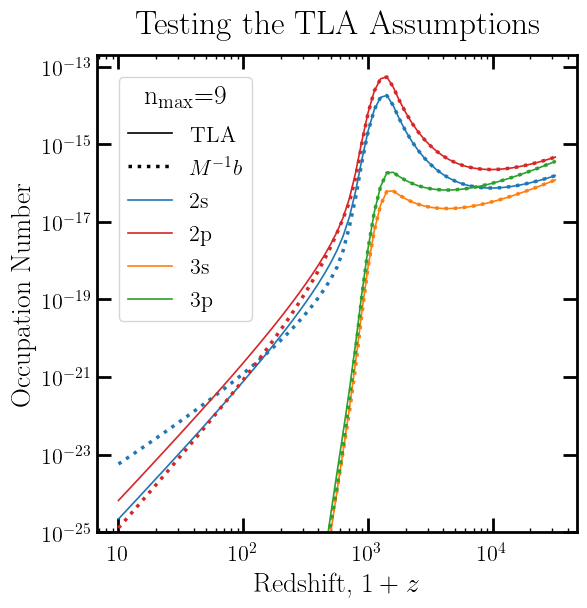

In [70]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=1.2

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$', color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

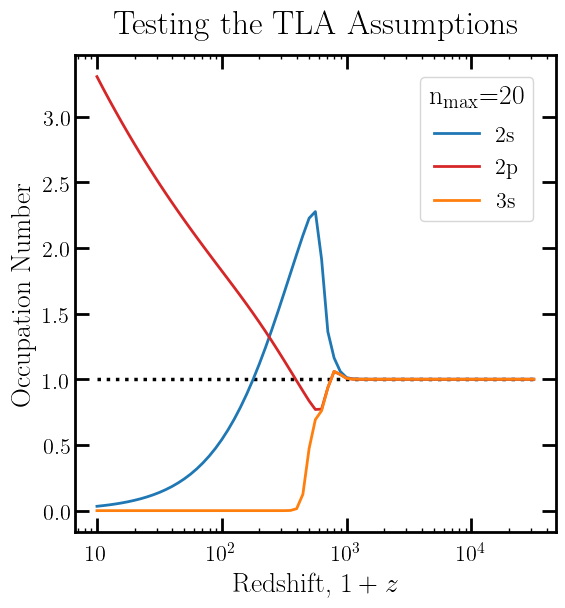

In [900]:
plt.figure()
# plt.loglog()
plt.xscale('log')
# plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=2.0

# plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec/x_vec[:,0], label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec, 3*x2s_vec/x_vec[:,1], label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec)/x_vec[:,2], 
         label='3s', color='C1', linewidth=lw)


# plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

# plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

# Distortion

In [949]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
tau=1e25
species = 'elec'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
test_main = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=tau,
    primary=species+'_delta',
    start_rs = 3e3,
    coarsen_factor=12, backreaction=False, distort=False,
#     struct_boost=struct_boost,
    end_rs=2.5e3
)

In [950]:
spec10  = test_main['highengphot'][-1]
spec10.redshift(1)

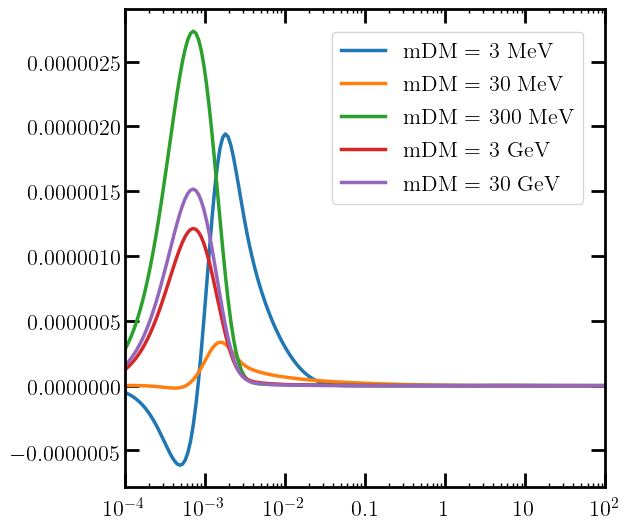

In [951]:
plt.figure()
plt.xscale('log')
plt.xlim([1e-4,100])
plt.plot(spec6.eng, spec6.eng*spec6.dNdE, label='mDM = 3 MeV')
plt.plot(spec.eng, spec.eng*spec.dNdE, label='mDM = 30 MeV')
plt.plot(spec8.eng, spec8.eng*spec8.dNdE, label='mDM = 300 MeV')
plt.plot(spec9.eng, spec9.eng*spec9.dNdE, label='mDM = 3 GeV')
plt.plot(spec10.eng, spec10.eng*spec10.dNdE, label='mDM = 30 GeV')
plt.legend()